### jijmodelingの動作確認

In [1]:
import jijmodeling as jm

d = jm.Placeholder('d', ndim=2)
N = d.len_at(0, latex="N")
i = jm.Element('i', belong_to=(0, N))
j = jm.Element('j', belong_to=(0, N))
t = jm.Element('t', belong_to=(0, N))
x = jm.BinaryVar('x', shape=(N, N))

In [4]:
problem = jm.Problem("TSP")
problem += jm.sum([i, j], d[i, j] * jm.sum(t, x[i, t]*x[j, (t+1) % N]))
problem += jm.Constraint("one-city", x[:, t].sum() == 1, forall=t)
problem += jm.Constraint("one-time", x[i, :].sum() == 1, forall=i)
problem

### ommxの動作確認

In [13]:
# # ommxのモジュール内容を確認
# import ommx.v1 as ommx

# print("ommx.v1で利用可能な主要なクラス:")
# print([attr for attr in dir(ommx) if not attr.startswith('_')])
# print("\nDecisionVariableのメソッド:")
# print([attr for attr in dir(ommx.DecisionVariable) if not attr.startswith('_')][:20])

### JijZeptSolverの動作確認

In [14]:
%%capture

# Install the required library
%pip install geopy

In [15]:
from geopy.geocoders import Nominatim
import numpy as np

geolocator = Nominatim(user_agent='python')

# set the name list of traveling points
points = ['茨城県', '栃木県', '群馬県', '埼玉県', '千葉県', '東京都', '神奈川県']

# get the latitude and longitude
latlng_list = []
for point in points:
    location = geolocator.geocode(point)
    if location is not None:
        latlng_list.append([ location.latitude, location.longitude ])
# make distance matrix
num_points = len(points)
inst_d = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(num_points):
        a = np.array(latlng_list[i])
        b = np.array(latlng_list[j])
        inst_d[i][j] = np.linalg.norm(a-b)
# normalize distance matrix
inst_d = (inst_d-inst_d.min()) / (inst_d.max()-inst_d.min())

geo_data = {'points': points, 'latlng_list': latlng_list}
instance_data = {'d': inst_d}

In [16]:
import jijzept_solver

interpreter = jm.Interpreter(instance_data)
instance = interpreter.eval_problem(problem)
solution = jijzept_solver.solve(instance, time_limit_sec=1.0)

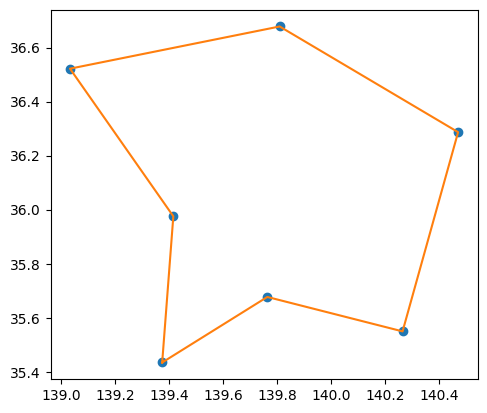

['神奈川県' '東京都' '千葉県' '茨城県' '栃木県' '群馬県' '埼玉県' '神奈川県']


In [17]:
import matplotlib.pyplot as plt

df = solution.decision_variables_df
x_indices = df[df["value"] == 1.0]["subscripts"]
tour = [index for index, _ in sorted(x_indices, key=lambda x: x[1])]
tour.append(tour[0])

position = np.array(geo_data['latlng_list']).T[[1, 0]]

plt.axes().set_aspect('equal')
plt.plot(*position, "o")
plt.plot(position[0][tour], position[1][tour], "-")
plt.show()

print(np.array(geo_data['points'])[tour])